In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/qa-intents-dataset-university-domain/dataset_test.tsv
/kaggle/input/qa-intents-dataset-university-domain/labels_description.txt
/kaggle/input/qa-intents-dataset-university-domain/dataset_train.tsv


In [2]:
train_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_train.tsv',delimiter='\t',encoding="utf-8",names=['text', 'intent'])
test_data = pd.read_csv('../input/qa-intents-dataset-university-domain/dataset_test.tsv',delimiter='\t',encoding="utf-8",names=['text', 'intent'])
train_data.head()

,text,intent
0,мне нужна справка,statement_general
1,оформить справку,statement_general
2,взять справку,statement_general
3,справку как получить,statement_general
4,справку ммф где получаться,statement_general


In [3]:
full_data = pd.concat([train_data, test_data])
full_data.head()

,text,intent
0,мне нужна справка,statement_general
1,оформить справку,statement_general
2,взять справку,statement_general
3,справку как получить,statement_general
4,справку ммф где получаться,statement_general


In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14113 entries, 0 to 882
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14113 non-null  object
 1   intent  14113 non-null  object
dtypes: object(2)
memory usage: 330.8+ KB


In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(full_data, test_size=0.2, random_state=42)

In [6]:
unique_values_normalized = train['intent'].value_counts(normalize=True)
print(unique_values_normalized*100)

intent
sched_teacher                8.582817
sched_for_group              3.126661
sched_for_group_day          3.046944
wifi                         2.143490
status_free                  2.037201
                               ...   
loc_nsu_cafeteria            0.168291
location_general             0.168291
student_trade_union_enter    0.159433
staff_trade_union_enter      0.159433
loc_passport_office          0.159433
Name: proportion, Length: 142, dtype: float64


In [7]:
unique_values_normalized2 = test['intent'].value_counts(normalize=True)
print(unique_values_normalized2*100)

intent
sched_teacher              7.616011
sched_for_group_day        3.010981
sched_for_group            2.833865
wifi                       2.267092
status_free                2.054552
                             ...   
staff_trade_union_enter    0.106270
loc_print_docs             0.106270
volunteer_become           0.106270
nsu_foundation_date        0.070847
location_general           0.070847
Name: proportion, Length: 142, dtype: float64


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2823 entries, 8079 to 8188
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2823 non-null   object
 1   intent  2823 non-null   object
dtypes: object(2)
memory usage: 66.2+ KB


In [9]:
from transformers import BertTokenizer

In [10]:
# Создание токенизатора BERT
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [11]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")


In [12]:
# Преобразование текста в токены
input_texts = train['text'].values.tolist()  # Преобразуйте тексты в список
input_ids = tokenizer.batch_encode_plus(input_texts, add_special_tokens=True, padding=True, truncation=True, max_length=64, return_tensors='pt')['input_ids']
# labels = torch.tensor(train_data['intent'].values)

In [13]:
# Преобразование меток в числовой формат
unique_intents = train['intent'].unique().tolist()
intent_mapping = {intent: i for i, intent in enumerate(unique_intents)}
train_labels = [intent_mapping[intent] for intent in train['intent']]
test_labels = [intent_mapping[intent] for intent in test['intent']]

In [14]:
import torch
import torch.nn as nn
from transformers import BertForSequenceClassification, AdamW

In [15]:
# Загрузка предобученной модели BERT
#model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_data['intent'].unique()))

#ruberttiny
# model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

model = BertForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2", num_labels=len(unique_intents))


# Определение оптимизатора
optimizer = AdamW(model.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# # Преобразование текста в токены и создание маски внимания
# input_ids = tokenizer.encode(train_data['text'].values, add_special_tokens=True, padding=True, truncation=True, max_length=64, return_tensors='pt')
# #labels = torch.tensor(train_data['intent'].values)

# Преобразование текста в токены и создание маски внимания
encoding = tokenizer.batch_encode_plus(
    train['text'].values.tolist(),  # Преобразуйте тексты в список
    add_special_tokens=True,
    padding=True,
    truncation=True,
    max_length=64,
    return_tensors='pt'
)
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses, n_epoches):
#     plt.plot(loss_values)
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Training Loss')
#     plt.show()
    
    # Построение графика потерь
    plt.plot(range(1, n_epoches + 1), train_losses, label='Train Loss')
    plt.plot(range(1, n_epoches + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [17]:
from torch.utils.data import Dataset, DataLoader

class IntentClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Создание DataLoader
def create_data_loader(texts, labels, tokenizer, max_len, batch_size):
    ds = IntentClassificationDataset(
        texts=texts,
        labels=labels,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size
    )

# Использование DataLoader в вашем коде
batch_size = 8 # 16
max_len = 64
train_data_loader = create_data_loader(train['text'].values.tolist(), train_labels, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(test['text'].values.tolist(), test_labels, tokenizer, max_len, batch_size)

In [18]:
# print(next(iter(train_data_loader)))

In [19]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score

train bert

In [20]:
# # Количество эпох
# epochs = 5

# # Список для хранения значений потерь на каждой эпохе
# loss_values = []
# best_loss = float('inf')
# best_acc = 0.8

# for epoch in range(epochs):
#     model.train()
#     total_loss = 0

#     # Используйте tqdm для отображения прогресса
#     for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}"):
#         optimizer.zero_grad()
#         input_ids = batch['input_ids']
#         attention_mask = batch['attention_mask']
#         labels = batch['labels']

#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         total_loss += loss.item()
#         loss.backward()
#         optimizer.step()

#     avg_train_loss = total_loss / len(train_data_loader)
#     loss_values.append(avg_train_loss)

#     print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}")

#     model.eval()
#     predictions , true_labels = [], []

#     for batch in tqdm(test_data_loader, desc=f"Validation Epoch {epoch+1}"):
#         with torch.no_grad():
#             input_ids = batch['input_ids']
#             attention_mask = batch['attention_mask']
#             labels = batch['labels']

#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             logits = outputs.logits
#             logits = logits.detach().cpu().numpy()
#             label_ids = labels.to('cpu').numpy()
            
#             print(logits.shape)
#             predictions.extend(np.argmax(logits, axis=1).flatten())
#             true_labels.extend(label_ids.flatten())

#     acc = accuracy_score(true_labels, predictions)
#     rec = recall_score(true_labels, predictions, average='weighted')
#     f1 = f1_score(true_labels, predictions, average='weighted')

#     print(f"Accuracy: {acc:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

#     # Ранняя остановка по потерям на валидации
#     if avg_train_loss > best_loss:
#         print("Early stopping due to increase in validation loss")
#         break

#     # Ранняя остановка по точности на валидации
#     if acc >= best_acc:
#         print("Early stopping due to reaching target accuracy")
#         break

#     best_loss = avg_train_loss

# plot_loss(loss_values)

Epoch 1: 100%|██████████| 1412/1412 [00:19<00:00, 72.33it/s]


Epoch: 1, Train Loss: 1.5639


Validation Epoch 1: 100%|██████████| 353/353 [00:01<00:00, 187.07it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced acc: 0.7463123212045271
Weighted precision, recall, fscore: (0.833718951325191, 0.824300389656394, 0.8051867592844008, None)


Epoch 2: 100%|██████████| 1412/1412 [00:19<00:00, 73.37it/s]


Epoch: 2, Train Loss: 0.4597


Validation Epoch 2: 100%|██████████| 353/353 [00:01<00:00, 190.89it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced acc: 0.8681383551571211
Weighted precision, recall, fscore: (0.8956731493828851, 0.8976266383280198, 0.8896115688662508, None)


Epoch 3: 100%|██████████| 1412/1412 [00:19<00:00, 73.69it/s]


Epoch: 3, Train Loss: 0.4165


Validation Epoch 3: 100%|██████████| 353/353 [00:01<00:00, 190.73it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced acc: 0.8319919523346014
Weighted precision, recall, fscore: (0.881041207781805, 0.8675168260715551, 0.8608200694113918, None)


Epoch 4: 100%|██████████| 1412/1412 [00:18<00:00, 74.58it/s]


Epoch: 4, Train Loss: 0.4959


Validation Epoch 4: 100%|██████████| 353/353 [00:01<00:00, 177.24it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced acc: 0.7765791734068451
Weighted precision, recall, fscore: (0.8380070791294458, 0.8289054197662061, 0.814372380627911, None)


Epoch 5: 100%|██████████| 1412/1412 [00:19<00:00, 73.87it/s]


Epoch: 5, Train Loss: 0.6663


Validation Epoch 5: 100%|██████████| 353/353 [00:01<00:00, 191.69it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced acc: 0.8510543296230807
Weighted precision, recall, fscore: (0.8897347036491218, 0.8781438186326603, 0.8696461458013159, None)


Epoch 6: 100%|██████████| 1412/1412 [00:19<00:00, 73.44it/s]


Epoch: 6, Train Loss: 0.4754


Validation Epoch 6: 100%|██████████| 353/353 [00:01<00:00, 191.65it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced acc: 0.8843535788033339
Weighted precision, recall, fscore: (0.9116642769625455, 0.9032943676939427, 0.8980299003360005, None)


Epoch 7: 100%|██████████| 1412/1412 [00:19<00:00, 73.44it/s]


Epoch: 7, Train Loss: 0.3653


Validation Epoch 7: 100%|██████████| 353/353 [00:01<00:00, 181.32it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced acc: 0.8695138861434164
Weighted precision, recall, fscore: (0.896634065098461, 0.8908962097059865, 0.8845757504192157, None)


Epoch 8: 100%|██████████| 1412/1412 [00:18<00:00, 74.62it/s]


Epoch: 8, Train Loss: 0.4673


Validation Epoch 8: 100%|██████████| 353/353 [00:01<00:00, 191.97it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced acc: 0.6990168297364457
Weighted precision, recall, fscore: (0.8288682661191529, 0.7881686149486362, 0.7745263940517205, None)


Epoch 9: 100%|██████████| 1412/1412 [00:19<00:00, 73.91it/s]


Epoch: 9, Train Loss: 0.4368


Validation Epoch 9: 100%|██████████| 353/353 [00:01<00:00, 196.93it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced acc: 0.8650296888591501
Weighted precision, recall, fscore: (0.895209010893302, 0.8916046758767269, 0.8863274034745552, None)


Epoch 10: 100%|██████████| 1412/1412 [00:19<00:00, 74.08it/s]


Epoch: 10, Train Loss: 0.4255


Validation Epoch 10: 100%|██████████| 353/353 [00:01<00:00, 186.20it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced acc: 0.8422936415254438
Weighted precision, recall, fscore: (0.8891540607422785, 0.8827488487424725, 0.8746757391400612, None)


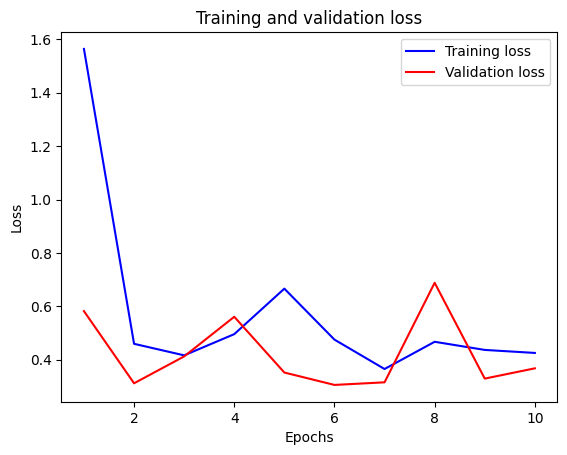

In [21]:
from transformers import BertForSequenceClassification
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support

# tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
# model = BertForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2")

# Количество эпох
epochs = 10

train_losses = []
val_losses = []

# Список для хранения значений потерь на каждой эпохе
loss_values = []
best_loss = float('inf')
best_acc = 0.98

for epoch in range(epochs):
    model.train()
    train_loss = 0
    val_loss = 0
    # Используйте tqdm для отображения прогресса
    for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        # Move tensors to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_data_loader)
    loss_values.append(avg_train_loss)

    print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    model.eval()
    predictions, true_labels = [], []

    for batch in tqdm(test_data_loader, desc=f"Validation Epoch {epoch+1}"):
        with torch.no_grad():
            # Move tensors to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            predictions.extend(np.argmax(logits, axis=1).flatten())
            true_labels.extend(label_ids.flatten())

    avg_val_loss = val_loss / len(test_data_loader)
    print("Balanced acc:", balanced_accuracy_score(true_labels, predictions))
    print("Weighted precision, recall, fscore:", precision_recall_fscore_support(true_labels, predictions, average='weighted'))

    best_loss = avg_train_loss

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

# Plotting loss graph
def plot_loss(train_losses, val_losses, n_epochs):
    import matplotlib.pyplot as plt

    epochs = range(1, n_epochs + 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(train_losses, val_losses, epochs)


In [22]:
# from transformers import BertForSequenceClassification

# # tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
# # model = BertForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2")

# # Количество эпох
# epochs = 7

# train_losses = []
# val_losses = []

# # Список для хранения значений потерь на каждой эпохе
# loss_values = []
# best_loss = float('inf')
# best_acc = 0.98

# for epoch in range(epochs):
#     model.train()
# #     total_loss = 0
#     train_loss = 0
#     val_loss = 0
#     # Используйте tqdm для отображения прогресса
#     for batch in tqdm(train_data_loader, desc=f"Epoch {epoch+1}"):
#         optimizer.zero_grad()
# #         input_ids = batch['input_ids']
# #         attention_mask = batch['attention_mask']
# #         labels = batch['labels']
#         # Move tensors to device
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)


#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         # total_loss += loss.item()
#         train_loss += loss.item()
#         loss.backward()
#         optimizer.step()

#     avg_train_loss = total_loss / len(train_data_loader)
#     loss_values.append(avg_train_loss)

#     print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}")

#     model.eval()
#     predictions , true_labels = [], []

#     for batch in tqdm(test_data_loader, desc=f"Validation Epoch {epoch+1}"):
#         with torch.no_grad():
# #             input_ids = batch['input_ids']
# #             attention_mask = batch['attention_mask']
# #             labels = batch['labels']
#             # Move tensors to device
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['labels'].to(device)


#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             logits = outputs.logits
#             logits = logits.detach().cpu().numpy()
#             label_ids = labels.to('cpu').numpy()
            
#             val_loss += loss.item()
            
#             # print(logits.shape)
#             predictions.extend(np.argmax(logits, axis=1).flatten())
#             true_labels.extend(label_ids.flatten())

# #     acc = accuracy_score(true_labels, predictions)
# #     rec = recall_score(true_labels, predictions, average='weighted')
# #     f1 = f1_score(true_labels, predictions, average='weighted')

# #     print(f"Accuracy: {acc:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")
#     print("Balanced acc:", balanced_accuracy_score(true_labels, predictions))
#     print("Weighted precision, recall, fscore:", precision_recall_fscore_support(true_labels, predictions, average='weighted'))

# #     # Ранняя остановка по потерям на валидации
# #     if avg_train_loss > best_loss:
# #         print("Early stopping due to increase in validation loss")
# #         break

# #     # Ранняя остановка по точности на валидации
# #     if acc >= best_acc:
# #         print("Early stopping due to reaching target accuracy")
# #         break

#     best_loss = avg_train_loss
    
#     train_loss /= len(train_loader)
#     val_loss /= len(test_loader)
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)


# plot_loss(val_loss, train_loss, n_epoches)


In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import timeit

In [24]:
# Предсказание на тестовых данных
model.eval()
predictions = []
start_test = timeit.default_timer()
with torch.no_grad():
    for batch in test_data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        predictions.extend(preds)
end_test = timeit.default_timer()
predicted_labels = [pred.item() for pred in predictions]

# Общее количество предсказанных ответов
num_predictions = len(predictions)

# Среднее время на один ответ
average_time_per_response = (end_test - start_test) / num_predictions

print(f'Time for testing: {end_test - start_test:.4f} seconds')
print(f'Average time per response: {average_time_per_response:.6f} seconds')

Time for testing: 1.6551 seconds
Average time per response: 0.000586 seconds


In [25]:
# print(balanced_accuracy_score(test_labels, predicted_labels))

In [26]:
print(balanced_accuracy_score(test_labels, predicted_labels))
print(precision_recall_fscore_support(test_labels, predicted_labels, average='weighted'))

0.8422936415254438
(0.8891540607422785, 0.8827488487424725, 0.8746757391400612, None)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Построение confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
print(f'Confusion Matrix: \n{cm}')

Confusion Matrix: 
[[ 53   0   0 ...   0   0   0]
 [  0 215   0 ...   0   0   0]
 [  0   0  16 ...   0   0   0]
 ...
 [  0   0   0 ...   7   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   4]]


In [28]:
# # Визуализация матрицы ошибок с использованием seaborn
# plt.figure(figsize=(20, 20))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(test_labels), yticklabels=set(predicted_labels))
# plt.xlabel('Предсказанный класс')
# plt.ylabel('Истинный класс')
# plt.title('Матрица ошибок')
# plt.show()
